In [80]:
import pandas as pd
import seaborn as sns
import numpy as np

Events_Sequence = pd.read_csv('Events_Sequence.txt', sep = '\t')
aircraft = pd.read_csv('aircraft.txt')
occurrences = pd.read_csv('Occurrences.txt', sep = ',')
seq_of_events = pd.read_csv('seq_of_events.txt', sep = '\t')
eventCodes = pd.read_csv('ct_seqevt.txt')

ev_ID = sum(aircraft.values.tolist(), [])

In [81]:
len(ev_ID)

2243

In [82]:
Events_Sequence.head(2)

,ev_id,Aircraft_Key,Occurrence_No,Occurrence_Code,Occurrence_Description,phase_no,eventsoe_no,Defining_ev,lchg_date,lchg_userid
0,20001208X08803,1,3,400240,Enroute - Loss of control in flight,400,240,1,5/13/2019 14:50:49,bowl
1,20001212X19469,1,1,550900,Landing - Miscellaneous/other,550,900,1,6/25/2015 14:54:25,sedj


In [83]:
new = Events_Sequence["Occurrence_Description"].str.split("-", n = 1, expand = True)

Events_Sequence.insert(5, 'Phase', 'Unknown')
Events_Sequence.insert(6, 'Description', 'Unknown')
Events_Sequence['Phase'] = new[0].str.strip()
Events_Sequence['Description'] = new[1].str.strip()

In [84]:
Events_Sequence.head()

,ev_id,Aircraft_Key,Occurrence_No,Occurrence_Code,Occurrence_Description,Phase,Description,phase_no,eventsoe_no,Defining_ev,lchg_date,lchg_userid
0,20001208X08803,1,3,400240,Enroute - Loss of control in flight,Enroute,Loss of control in flight,400,240,1,5/13/2019 14:50:49,bowl
1,20001212X19469,1,1,550900,Landing - Miscellaneous/other,Landing,Miscellaneous/other,550,900,1,6/25/2015 14:54:25,sedj
2,20010304X00536,1,1,400350,Enroute - Security/criminal event,Enroute,Security/criminal event,400,350,1,6/25/2015 15:51:08,sedj
3,20010304X00536,2,1,400350,Enroute - Security/criminal event,Enroute,Security/criminal event,400,350,1,6/25/2015 15:51:23,sedj
4,20080109X00036,1,1,551230,Landing-flare/touchdown - Loss of control on g...,Landing,flare/touchdown - Loss of control on ground,551,230,1,11/16/2017 13:41:08,broda


In [85]:
second_phases = ['cruise', 'flare/touchdown', 'aerobatics', 'climb to cruise', 'landing roll', 'IFR initial approach', 
                 'IFR final approach', 'IFR missed approach', 'low-alt flying', 'VFR go-around', 'descent', 
                 'VFR pattern final', 'rejected takeoff', 'circling (IFR)']
def f(x):
    if '-' in x:
        if x.split('-')[0].strip() in second_phases:
            return x.split('-', 1)[1].strip()
    else:
        return x

Events_Sequence['Description'] = Events_Sequence['Description'].map(f)

#### Accident proportion by phases

In [86]:
df_events_sequences = Events_Sequence[Events_Sequence['ev_id'].isin(ev_ID)]

df_events_sequences.reset_index(inplace=True)
del df_events_sequences['index']

In [87]:
df_events_sequences.head()

,ev_id,Aircraft_Key,Occurrence_No,Occurrence_Code,Occurrence_Description,Phase,Description,phase_no,eventsoe_no,Defining_ev,lchg_date,lchg_userid
0,20080118X00073,1,1,200200,Pushback/towing - Ground collision,Pushback/towing,Ground collision,200,200,1,2/2/2009 13:27:45,mcgk-c
1,20080118X00073,2,1,200200,Pushback/towing - Ground collision,Pushback/towing,Ground collision,200,200,1,2/2/2009 13:28:51,mcgk-c
2,20080222X00229,1,1,401900,Enroute-climb to cruise - Miscellaneous/other,Enroute,Miscellaneous/other,401,900,1,12/23/2008 15:40:20,stam
3,20080222X00229,1,2,402900,Enroute-cruise - Miscellaneous/other,Enroute,Miscellaneous/other,402,900,0,12/23/2008 15:40:20,stam
4,20080305X00267,1,1,404360,Enroute-descent - Turbulence encounter,Enroute,Turbulence encounter,404,360,1,7/28/2009 14:59:12,grol


In [88]:
import collections

counter = collections.Counter(df_events_sequences['Phase'])
counter

Counter({'Pushback/towing': 20,
         'Enroute': 170,
         'Taxi': 48,
         'Standing': 41,
         'Takeoff': 34,
         'Landing': 91,
         'Prior to flight': 25,
         'Initial climb': 37,
         'Approach': 46,
         'Pushback/tow': 14,
         'Post': 6,
         'Other': 9,
         'Unknown': 4,
         'Emergency descent': 2,
         'Uncontrolled descent': 1,
         'After landing': 4})

Text(0, 0.5, 'Proportion')

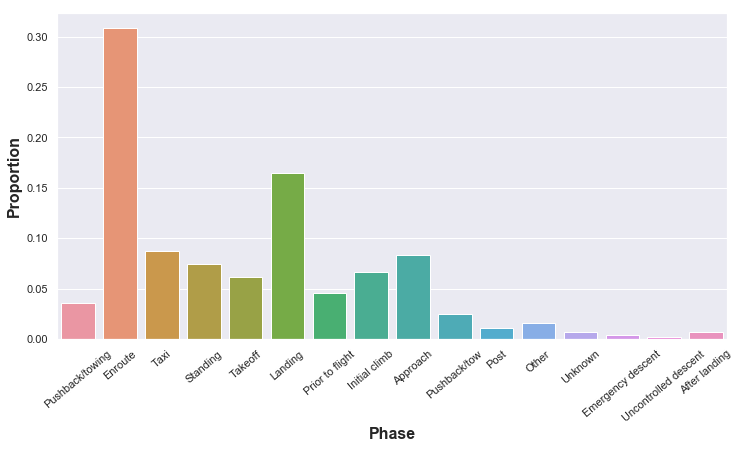

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

proportion = np.array(list(counter.values()))/sum(list(counter.values()))

plt.figure(figsize = (12, 6))
sns.barplot(x = list(counter.keys()), y = proportion)
sns.set(font_scale=1)
plt.xticks(rotation=40)
plt.xlabel('Phase', fontsize = 16, fontweight = 'bold')
plt.ylabel('Proportion', fontsize = 16, fontweight = 'bold')

#### Create raw transition graph from the Table Events_Sequence

In [90]:
nodeDesp = list(df_events_sequences['Description'].unique())

In [91]:
def findDespByID(ID):
    desp = df_events_sequences.loc[df_events_sequences['ev_id'] == ID]
    return list(desp['Description'])

dictEdges = {}

for ID in df_events_sequences['ev_id']:
    desp = findDespByID(ID)
    
    if len(desp) == 1:
        nodeFrom = nodeDesp.index(desp[0])
        nodeTo = nodeDesp.index(desp[0])
        
        key = str(nodeFrom)
        
        if key in dictEdges.keys():
            dictEdges[key] = dictEdges[key] + 1  
        else:
            dictEdges[key] = 1    
    else:
        for i in range(len(desp) - 1):
            nodeFrom = nodeDesp.index(desp[i])
            nodeTo = nodeDesp.index(desp[i+1])

            key = str(nodeFrom) + '->' + str(nodeTo)
            
            if key in dictEdges.keys():
                dictEdges[key] = dictEdges[key] + 1
            else:
                dictEdges[key] = 1

In [92]:
import operator

sorted_x = sorted(dictEdges.items(), key=operator.itemgetter(1))

In [93]:
import pygraphviz as pgv
from IPython.display import Image

def drawImage(dot):
    return Image(pgv.AGraph(dot).draw(format='jpg', prog='dot'))

def drawPDF(dot, fileName):
    return pgv.AGraph(dot).draw(fileName + '.pdf', prog='dot')

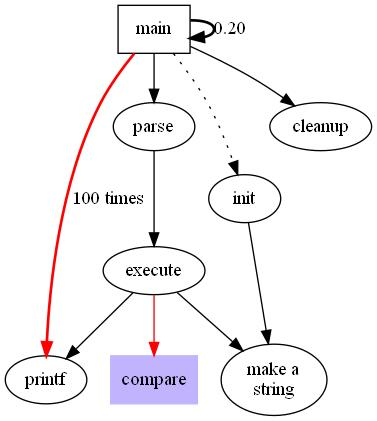

In [94]:
g1 = """digraph top {
    size ="12,12";
    main [shape=box]; /* this is a comment */
    main -> parse [weight=80];
    main -> main [style=bold, label="0.20"];
    parse -> execute;
    main -> init [style=dotted];
    main -> cleanup;
    execute -> { make_string; printf}
    init -> make_string;
    edge [color=red]; // so is this
    main -> printf [style=bold,label="100 times"];
    make_string [label="make a\nstring"];
    node [shape=box,style=filled,color=".7 .3 1.0"];
    execute -> compare;
}"""


drawImage(g1)

In [95]:
def create_graph():
    g = """digraph top {
    size ="12,12";"""
    
    for key, value in dictEdges.items():
        
        if '->' in key:
            nodeFrom = key.split('->')[0]
            nodeTo = key.split('->')[1]
            g += str(nodeFrom) + '->' + str(nodeTo) + '[style=bold, label=' + str(value) + ']'
  
    g += '}'
    
    return g

In [96]:
nodeDesp[21]

'Fire/smoke (non-impact)'

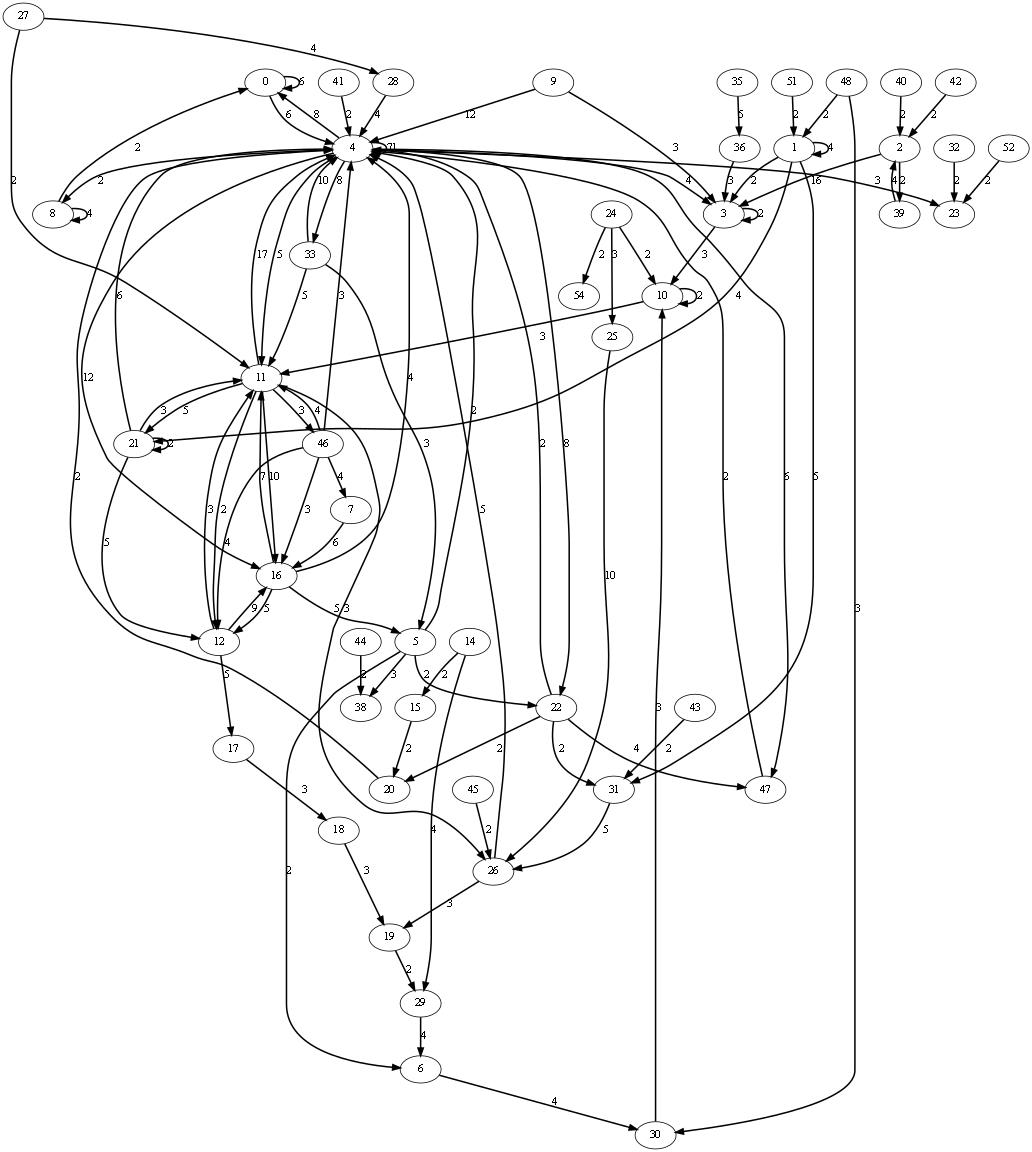

In [97]:
g = create_graph()
drawPDF(g, 'test')
drawImage(g)

#### Create Bayesian network from Table seq_of_events

In [173]:
initialIDs = set(occurrences['ev_id']).intersection(set(seq_of_events['ev_id']))
part120_IDs = set(sum(aircraft.values.tolist(), []))

ev_ID = list(initialIDs.intersection(part120_IDs))

In [174]:
eventCodes.head()

,code,meaning
0,100,ABRUPT MANEUVER
1,110,"ALTITUDE DEVIATION,UNCONTROLLED"
2,120,CARGO SHIFT
3,130,AIRFRAME/COMPONENT/SYSTEM FAILURE/MALFUNCTION
4,131,PROPELLER FAILURE/MALFUNCTION


In [181]:
df_seq_of_events = seq_of_events[seq_of_events['ev_id'].isin(ev_ID)].copy()

df_seq_of_events.drop(df_seq_of_events.index[6218], inplace = True)
df_seq_of_events.reset_index(inplace=True)
del df_seq_of_events['index']

In [182]:
df_seq_of_events.head()

,ev_id,Aircraft_Key,Occurrence_No,seq_event_no,group_code,Subj_Code,Cause_Factor,Modifier_Code,Person_Code,lchg_date,lchg_userid
0,20030314X00332,1,1,1,1,10403,C,1137,0.0,7/6/2004 15:23:06,JOHB
1,20001212X18554,1,1,1,2,24602,F,3130,4000.0,1/10/2001 10:43:11,dbo
2,20001212X18554,1,1,2,2,24608,C,3130,4111.0,1/10/2001 10:43:11,dbo
3,20001212X18554,1,1,3,4,90000,F,0,6110.0,1/10/2001 10:43:11,dbo
4,20001212X18554,1,1,4,2,24604,F,3134,4111.0,1/10/2001 10:43:11,dbo


In [183]:
df_seq_of_events.insert(6, 'Grouped_Subject_Code', None)

In [184]:
df_seq_of_events['Grouped_Subject_Code'] = df_seq_of_events['Subj_Code'].copy()

def updateGroupSubjectCode(code):
    #codeList = [24600, 24500, 10400, 24000, 19000, 10700, 12000, 12100, 19200, 14100, 14300,
    #            33000, 12900, 10000, 20200, 22100, 23300, 24100, 16900, 17000, 10300]
    codeList = []
    
    if int(str(code)[:-2] + '00') in codeList:
        return code
    else:
        return int(str(code)[:-2] + '00')
        
df_seq_of_events['Grouped_Subject_Code'] = df_seq_of_events['Grouped_Subject_Code'].map(updateGroupSubjectCode)

In [185]:
df_seq_of_events.head()

,ev_id,Aircraft_Key,Occurrence_No,seq_event_no,group_code,Subj_Code,Grouped_Subject_Code,Cause_Factor,Modifier_Code,Person_Code,lchg_date,lchg_userid
0,20030314X00332,1,1,1,1,10403,10400,C,1137,0.0,7/6/2004 15:23:06,JOHB
1,20001212X18554,1,1,1,2,24602,24600,F,3130,4000.0,1/10/2001 10:43:11,dbo
2,20001212X18554,1,1,2,2,24608,24600,C,3130,4111.0,1/10/2001 10:43:11,dbo
3,20001212X18554,1,1,3,4,90000,90000,F,0,6110.0,1/10/2001 10:43:11,dbo
4,20001212X18554,1,1,4,2,24604,24600,F,3134,4111.0,1/10/2001 10:43:11,dbo


In [186]:
def findKeyByValue(val, highLevelGroup):
    for k, v in highLevelGroup.items():
        if val in v:
            return k
        
def mapToHigherLevel(code):
    highLevelGroup = {
        31000: [31100, 31200],
        33000: [33100, 33200, 33300, 33400, 33500, 33600, 33700],
        34000: [34100, 34200, 34300],
        35000: [35100, 35200, 35300],
        70000: [70100],
        80000: [80100, 80200, 80300, 80400],
        84000: [84100, 84200],
        90000: [90100, 90200], 
        91000: [91100, 91200, 91300, 91400, 91500], 
        92000: [92100, 92200, 92300, 92400],
        93000: [93100, 93200, 93300]
    }
    
    allValues = sum(list(highLevelGroup.values()), []) 
    
    if code in allValues:
        key = findKeyByValue(code, highLevelGroup)
        return key
    else:
        return code
    
df_seq_of_events['Grouped_Subject_Code'] = df_seq_of_events['Grouped_Subject_Code'].map(mapToHigherLevel)

In [187]:
df_seq_of_events.head()

,ev_id,Aircraft_Key,Occurrence_No,seq_event_no,group_code,Subj_Code,Grouped_Subject_Code,Cause_Factor,Modifier_Code,Person_Code,lchg_date,lchg_userid
0,20030314X00332,1,1,1,1,10403,10400,C,1137,0.0,7/6/2004 15:23:06,JOHB
1,20001212X18554,1,1,1,2,24602,24600,F,3130,4000.0,1/10/2001 10:43:11,dbo
2,20001212X18554,1,1,2,2,24608,24600,C,3130,4111.0,1/10/2001 10:43:11,dbo
3,20001212X18554,1,1,3,4,90000,90000,F,0,6110.0,1/10/2001 10:43:11,dbo
4,20001212X18554,1,1,4,2,24604,24600,F,3134,4111.0,1/10/2001 10:43:11,dbo


In [188]:
subjectCodes = sorted(list(df_seq_of_events['Grouped_Subject_Code'].unique()))

In [189]:
df_seq_of_events.head(3)

,ev_id,Aircraft_Key,Occurrence_No,seq_event_no,group_code,Subj_Code,Grouped_Subject_Code,Cause_Factor,Modifier_Code,Person_Code,lchg_date,lchg_userid
0,20030314X00332,1,1,1,1,10403,10400,C,1137,0.0,7/6/2004 15:23:06,JOHB
1,20001212X18554,1,1,1,2,24602,24600,F,3130,4000.0,1/10/2001 10:43:11,dbo
2,20001212X18554,1,1,2,2,24608,24600,C,3130,4111.0,1/10/2001 10:43:11,dbo


In [190]:
def findEventSequence(ev_id):
    seqs = df_seq_of_events.loc[df_seq_of_events['ev_id'] == ev_id][['seq_event_no', 'Grouped_Subject_Code']]
    return seqs.drop_duplicates(subset = ['seq_event_no', 'Grouped_Subject_Code'])

def findEventOutcomes(ev_id):
    outcomes = occurrences.loc[occurrences['ev_id'] == ev_id][['Occurrence_No', 'Occurrence_Code']].copy()
    return outcomes.drop_duplicates(subset = ['Occurrence_No', 'Occurrence_Code'])


dictEventSequences = {}

for ID in ev_ID:

    seq = findEventSequence(ID)
    leafNodes = []

    if len(seq) > 0:
        for i in range(len(seq) - 1):

            if seq.iloc[i]['seq_event_no'] < seq.iloc[i+1]['seq_event_no']:
                codeFrom = seq.iloc[i]['Grouped_Subject_Code']
                codeTo = seq.iloc[i+1]['Grouped_Subject_Code']

                key = str(codeFrom) + '->' + str(codeTo)

                if key in dictEventSequences.keys():
                    dictEventSequences[key] += 1
                else:
                    dictEventSequences[key] = 1 
            else:
                leafNodes.append(seq.iloc[i]['Grouped_Subject_Code'])


        leafNodes.append(seq.iloc[-1]['Grouped_Subject_Code'])

        outcomes = findEventOutcomes(ID)

        ## connect leaft Nodes with event outcomes:
        for i in leafNodes:
            codeFrom = i
            codeTo = outcomes.iloc[0]['Occurrence_Code']

            key = str(codeFrom) + '->' + str(codeTo)
            if key in dictEventSequences.keys():
                dictEventSequences[key] += 1
            else:
                dictEventSequences[key] = 1

        outcomeLens = outcomes.shape[0]

        if outcomeLens > 1:
            for i in range(outcomeLens - 1):
                codeFrom = outcomes.iloc[i]['Occurrence_Code']
                codeTo = outcomes.iloc[i+1]['Occurrence_Code']

                key = str(codeFrom) + '->' + str(codeTo)

                if key in dictEventSequences.keys():
                    dictEventSequences[key] += 1
                else:
                    dictEventSequences[key] = 1

In [191]:
def createBN():
    
    occurrencesCodes = list(set(occurrences['Occurrence_Code']))
    
    g = """digraph top {
    \tsize ="12,12"; \n \t"""

    g_node_style = ''
    
    count = 0
    for key, value in dictEventSequences.items():
        
        if count < 80:
            if '->' in key:
                nodeFrom = int(key.split('->')[0])
                nodeTo = int(key.split('->')[1])

                #if nodeFrom == nodeTo:
                #    print (nodeFrom, '-->', nodeTo)
                
                if nodeFrom in occurrencesCodes:
                    g += str(nodeFrom) + '->' + str(nodeTo) + ' [label=' + str(value) + ']'
                    g += '\n\t'
                    
                    g_node_style += str(nodeFrom) + """ [style=filled, color=".7 .4 1.0"]"""
                    g_node_style += '\n\t'
                elif nodeTo in occurrencesCodes:
                    g += str(nodeFrom) + '->' + str(nodeTo) + ' [label=' + str(value) + ']'
                    g += '\n\t'
                    
                    g_node_style += str(nodeTo) + """ [style=filled, color=".7 .4 1.0"]"""
                    g_node_style += '\n\t'
                else:
                    g += str(nodeFrom) + '->' + str(nodeTo) + ' [style=bold, label=' + str(value) + ']'
                    g += '\n\t'
                    
            count += 1
      
    g += g_node_style
    g = g[:-1]
    g += '}'
    
    return g

In [192]:
dictSubjectCodes = {}
for i in range(1, len(subjectCodes)+1):
    dictSubjectCodes[subjectCodes[i-1]] = i

In [197]:
subjectCodes

[10000,
 10100,
 10200,
 10300,
 10400,
 10500,
 10600,
 10700,
 10800,
 11300,
 12000,
 12100,
 12200,
 12300,
 12400,
 12500,
 12600,
 12700,
 12800,
 12900,
 13000,
 13100,
 14000,
 14100,
 14200,
 14300,
 14400,
 14500,
 14600,
 14700,
 14800,
 14900,
 15000,
 15100,
 15200,
 15300,
 15400,
 15600,
 15700,
 15800,
 15900,
 16000,
 16700,
 16900,
 17000,
 17100,
 17200,
 17300,
 18100,
 18200,
 18300,
 18400,
 18500,
 19000,
 19200,
 19300,
 20000,
 20100,
 20200,
 21000,
 21100,
 22000,
 22100,
 22200,
 22300,
 22400,
 22500,
 22600,
 22700,
 22800,
 22900,
 23000,
 23100,
 23300,
 24000,
 24100,
 24200,
 24300,
 24400,
 24500,
 24600,
 24700,
 25000,
 30000,
 31000,
 32000,
 33000,
 34000,
 35000,
 40000,
 60000,
 70000,
 80000,
 82000,
 82100,
 82200,
 84000,
 90000,
 91000,
 92000,
 93000]

In [203]:
len(dictEventSequences)

1855

In [202]:
eventCodes[eventCodes['code'] == 200]

,code,meaning
22,200,HARD LANDING


In [195]:
eventCodes.head()

,code,meaning
0,100,ABRUPT MANEUVER
1,110,"ALTITUDE DEVIATION,UNCONTROLLED"
2,120,CARGO SHIFT
3,130,AIRFRAME/COMPONENT/SYSTEM FAILURE/MALFUNCTION
4,131,PROPELLER FAILURE/MALFUNCTION


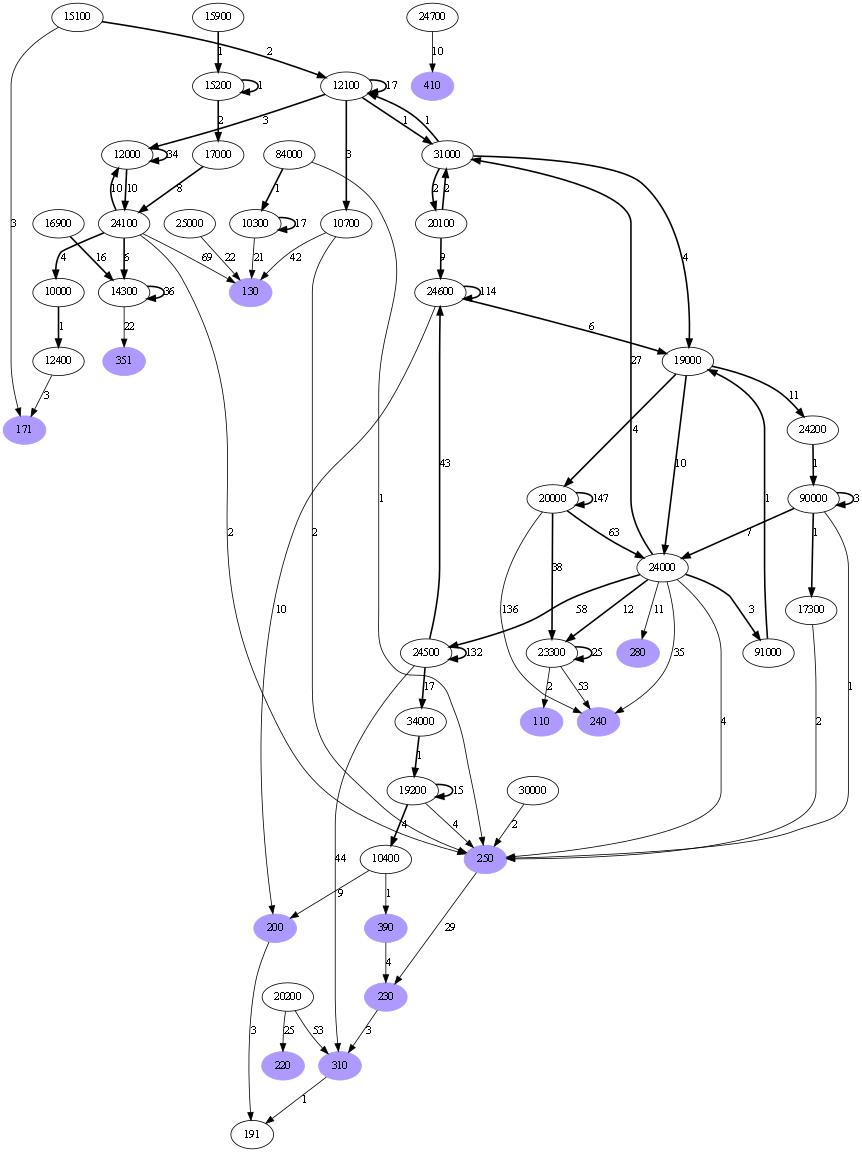

In [196]:
BN = createBN()
drawImage(BN)

In [143]:
#print (BN)

In [144]:
drawPDF(BN, 'BN')